In [1]:
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel
from diffusers import BitsAndBytesConfig
from transformers import CLIPTextModel, CLIPTextModelWithProjection
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
import gc

# Configurações
ckpt_id = "stabilityai/stable-diffusion-xl-base-1.0"
lora_path = "results"  # Caminho para sua pasta com LoRA (corrigido: "results" em vez de "result")
bnb_4bit_compute_dtype = torch.float16

# Configuração de quantização para diffusers (UNet)
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

# Configuração de quantização para transformers (text encoders)
quant_config = TransformersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

# Carregar UNet quantizado
print("Carregando UNet quantizado...")
unet = UNet2DConditionModel.from_pretrained(
    ckpt_id,
    subfolder="unet",
    quantization_config=nf4_config,
    torch_dtype=torch.float16
)

# Carregar text encoders quantizados
print("Carregando text encoders quantizados...")
text_encoder = CLIPTextModel.from_pretrained(
    ckpt_id,
    subfolder="text_encoder",
    quantization_config=quant_config,
    torch_dtype=torch.float16
)

text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(
    ckpt_id,
    subfolder="text_encoder_2",
    quantization_config=quant_config,
    torch_dtype=torch.float16
)

# Montar o pipeline com os componentes quantizados
print("Montando pipeline...")
pipeline = StableDiffusionXLPipeline.from_pretrained(
    ckpt_id,
    unet=unet,
    text_encoder=text_encoder,
    text_encoder_2=text_encoder_2,
    torch_dtype=bnb_4bit_compute_dtype,
)


# Liberar memória
del text_encoder
del text_encoder_2
del unet
gc.collect()
torch.cuda.empty_cache()

# Mover para GPU
print("Movendo pipeline para GPU...")
pipeline.to("cuda")

Carregando UNet quantizado...


`torch_dtype` is deprecated! Use `dtype` instead!


Carregando text encoders quantizados...
Montando pipeline...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Movendo pipeline para GPU...


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [13]:
pipeline.unload_lora_weights()

  0%|          | 0/28 [00:00<?, ?it/s]

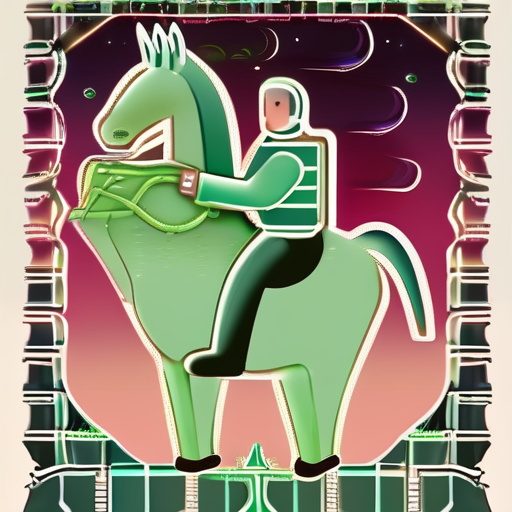

In [15]:
image = pipeline(
    "An astronaut riding a green horse", num_inference_steps=28, guidance_scale=3.5, height=512, width=512, generator=torch.manual_seed(0)
).images[0]
image


In [7]:
pipeline.load_lora_weights("results", weight_name="pytorch_lora_weights.safetensors")

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the war

  0%|          | 0/28 [00:00<?, ?it/s]

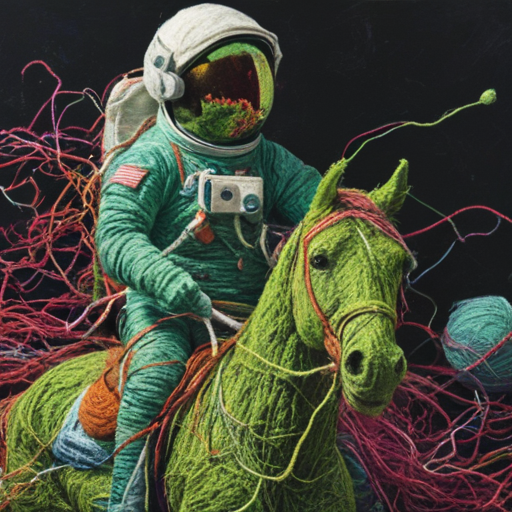

In [11]:
image = pipeline(
    "An astronaut riding a green horse, yarn style", num_inference_steps=28, guidance_scale=3.5, height=512, width=512, generator=torch.manual_seed(0)
).images[0]
image
